# Proyecto Final 🤖
Curso: NPL (Coder House)

**Alumno: Luciano Delgado**

In [12]:
import pandas as pd

### Procesamiento de texto
import re
import inflect
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

### Model Building & Feature Selection & Parameter Tuning ###
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

### Classification Algos ###
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier

### Evaluation & Visualization Modules ###
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt

Descargo un dataset de mails clasificados como Spam/NoSpam, con las labels ya predefinidas (este proceso en general lo hace un humano uno a uno y sirve como input al modelo que uno quiera aplicar)

In [18]:
# Descargo de la sección "Archivos" dentro de este notebook
df = pd.read_csv(r'spam_or_not_spam.csv')
df

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [19]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [21]:
df.dropna(inplace=True)

In [22]:
df['label'].value_counts()

,count
label,
0,2500
1,499


In [23]:
duplicates_df = df[df.duplicated()]
duplicates_df.shape

(127, 2)

In [24]:
df


,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [25]:
df.drop_duplicates(inplace=True)
len(df)

2872

# Procesamiento de texto

In [26]:
def remove_punctuation(text):
    ### Remove the punctuation marks ###
    text = re.sub(r"\W", " ", text) # replaces anything other than letters, digits, underscore character with a white space
    text = re.sub(r'\s+', " ", text) # removes extra white spaces

    ### Lowercase the text ###
    text = text.lower()
    return text

df['email'] = df['email'].apply(remove_punctuation)
df.head()

,email,label
0,date wed number aug number number number numb...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


# Remuevo stopwords

In [28]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['email'] = df['email'].apply(remove_stopwords)

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,email,label
0,date wed number aug number number number numbe...,0
1,martin posted tassos papadopoulos greek sculpt...,0
2,man threatens explosion moscow thursday august...,0
3,klez virus die already prolific virus ever kle...,0
4,adding cream spaghetti carbonara effect pasta ...,0


Reemplazo dígitos por su representación textual

In [29]:

p = inflect.engine()
def convert_digits(text):
    words = text.split()
    new_text = []

    for word in words:
        if word.isdigit():
            new_text.append(p.number_to_words(word))
        else:
            new_text.append(word)

    return ' '.join(new_text)

df['email'] = df['email'].apply(convert_digits)

df.head()

,email,label
0,date wed number aug number number number numbe...,0
1,martin posted tassos papadopoulos greek sculpt...,0
2,man threatens explosion moscow thursday august...,0
3,klez virus die already prolific virus ever kle...,0
4,adding cream spaghetti carbonara effect pasta ...,0


In [30]:
# Steeming ???
ps = PorterStemmer()

def stemming(text):
    words = text.split()
    words = [ps.stem(word) for word in words]
    return ' '.join(words)

df['email'] = df['email'].apply(stemming)
df.head(10)

,email,label
0,date wed number aug number number number numbe...,0
1,martin post tasso papadopoulo greek sculptor b...,0
2,man threaten explos moscow thursday august num...,0
3,klez viru die alreadi prolif viru ever klez co...,0
4,ad cream spaghetti carbonara effect pasta make...,0
5,jump carbonara one favourit make ask hell supp...,0
6,scotsman number august number playboy want go ...,0
7,martin adamson wrote basic mixtur beaten egg b...,0
8,scotsman thu number aug number meaning sentenc...,0
9,tri research via sa mirror search engin can sc...,0


Vertorización

In [32]:
vectorizer = TfidfVectorizer()
x_vector = vectorizer.fit_transform(df['email'])
y = df['label']

Dividir en set de Entregmiento y Test

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_vector, y, test_size=0.3)

### Tuning parameters using multiple k values for selecting best number of features
param_grid = {
    'selector__k': [5, 10, 15, 20, 25, 30, 35, 40]
}

# Define a function to create pipelines and perform grid search for each classifier
def grid_search_for_classifier(clf, param_grid, x_train, y_train):
    pipeline = Pipeline([
        ('selector', SelectKBest(chi2)),
        ('classifier', clf)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
    grid_search.fit(x_train, y_train)

    return grid_search

# Algoritmo de clasificación y medición de Accuracy

**1. Classification: NaiveBayesMultinomial**

In [34]:
# Parameter Tuning & Training: Perform grid search for MultinomialNB
multinomial_nb = MultinomialNB()
grid_search_mnb = grid_search_for_classifier(multinomial_nb, param_grid, x_train, y_train)
best_mnb_model = grid_search_mnb.best_estimator_
# print(f"Best parameters for MultinomialNB: {grid_search_mnb.best_params_}")

# Predicting & Evaluating Accuracy: MultinomialNB
y_pred_mnb = best_mnb_model.predict(x_test)

mnb_accuracy = accuracy_score(y_test, y_pred_mnb)

print("MultinomialNB Accuracy Score: " + str(mnb_accuracy))
print("MultinomialNB Error Rate " + str(1-mnb_accuracy))

MultinomialNB Accuracy Score: 0.877030162412993
MultinomialNB Error Rate 0.12296983758700697


Matriz de confusión

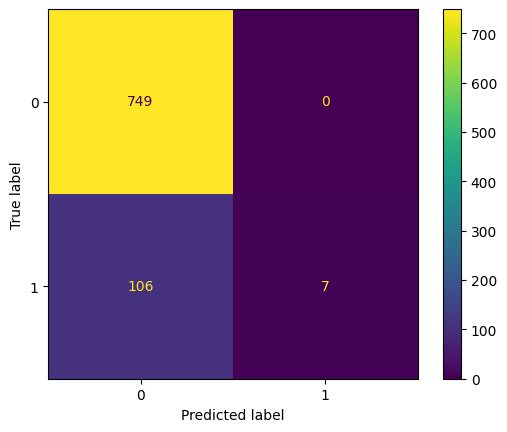

In [35]:
cm = confusion_matrix(y_test, y_pred_mnb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()

plt.show()


- No Spam: El modelo predijo todos los no-span con presición

- Spam: Predijo la mayoría falsamente como "No Spam"


**2. NaiveBayes: Gaussian NB**

In [36]:
# Parameter Tuning & Training: Perform grid search for GaussianNB (standard NaiveBayes)
# GaussianNB requires dense matrix
x_train_dense = x_train.toarray()
x_test_dense = x_test.toarray()
gaussian_nb = GaussianNB()
grid_search_gnb = grid_search_for_classifier(gaussian_nb, param_grid, x_train_dense, y_train)
best_gnb_model = grid_search_gnb.best_estimator_
# print(f"Best parameters for GaussianNB: {grid_search_gnb.best_params_}")

# Predicting & Evaluating accuracy: GaussianNB: NaiveBayes
y_pred_gnb = best_gnb_model.predict(x_test_dense)
gnb_accuracy = accuracy_score(y_test, y_pred_gnb)
print("GaussianNB Accuracy Score: " + str(gnb_accuracy))
print("GaussianNB Error Rate: " + str(1-gnb_accuracy))

GaussianNB Accuracy Score: 0.9222737819025522
GaussianNB Error Rate: 0.07772621809744784


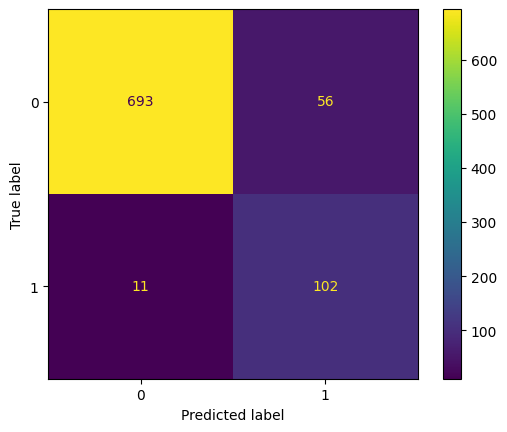

In [37]:
cm = confusion_matrix(y_test,y_pred_gnb)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()

plt.show()



- El modelo predijo todos los No Spam con precisión con algunos pocos predichos como Spam

- El modelo predijo la mayoría de los Spam correctamente con algunos falsamente predichos como No Spam

**3. J48 (Decision Tree Classifier)**

In [38]:
# Parameter Tuning & Training: Perform grid search for J48 (DecisionTreeClassifier)
j48 = DecisionTreeClassifier()
grid_search_j48 = grid_search_for_classifier(j48, param_grid, x_train, y_train)
best_j48_model = grid_search_j48.best_estimator_
# print(f"Best parameters for J48: {grid_search_j48.best_params_}")

# Predicting & Evaluating: J48
y_pred_j48 = best_j48_model.predict(x_test)
j48_accuracy = accuracy_score(y_test, y_pred_j48)
print("J48 Accuracy Score:" + str(j48_accuracy))
print("J48 Error Rate:" + str(1-j48_accuracy))

J48 Accuracy Score:0.974477958236659
J48 Error Rate:0.025522041763341052


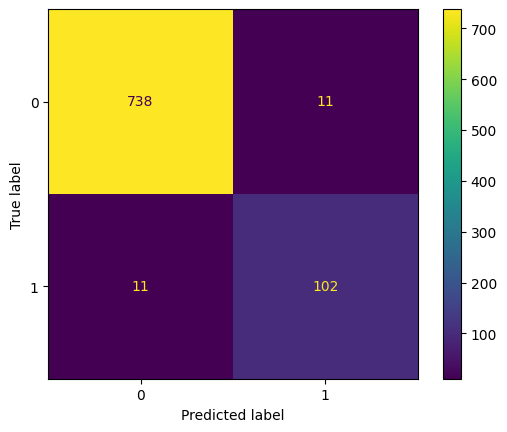

In [39]:
cm = confusion_matrix(y_test,y_pred_j48)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()

plt.show()



J48 o Decision Tree predijo la mayoria de los No Spam con precisión así como también los Spam. Ambos presentando un alto grado de accuracy superior al 90%